# Ising Model in Julia


## Instructions for running Julia on Colab
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_. Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [2]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots" # add julia package you want to use here
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [3]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Apple M1
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, westmere)


In [7]:
using BenchmarkTools

M = rand(2048, 2048)
@benchmark M^2

BenchmarkTools.Trial: 24 samples with 1 evaluation.
 Range (min … max):  200.797 ms … 255.256 ms  ┊ GC (min … max): 0.00% … 17.59%
 Time  (median):     205.538 ms               ┊ GC (median):    0.13%
 Time  (mean ± σ):   211.096 ms ±  13.332 ms  ┊ GC (mean ± σ):  1.92% ±  4.65%

  ▁▁ ▄█      ▁ ▁   ▁                                             
  ██▆██▆▆▁▁▁▁█▁█▆▁▁█▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▆ ▁
  201 ms           Histogram: frequency by time          255 ms <

 Memory estimate: 32.00 MiB, allocs estimate: 2.

In [5]:
using Pkg
Pkg.add.(["Flux", "Random", "Statistics","BenchmarkTools"])

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed OpenSpecFun_jll ────── v0.5.5+0
   Installed ZygoteRules ────────── v0.2.1
   Installed CodecZlib ──────────── v0.7.0
   Installed IrrationalConstants ── v0.1.0
   Installed NNlibCUDA ──────────── v0.1.8
   Installed AbstractFFTs ───────── v1.0.1
   Installed Random123 ──────────── v1.4.2
   Installed Flux ───────────────── v0.12.6
   Installed Functors ───────────── v0.2.4
   Installed LogExpFunctions ────── v0.3.0
   Installed ExprTools ──────────── v0.1.6
   Installed NNlib ──────────────── v0.7.28
   Installed RandomNumbers ──────── v1.5.3
   Installed TranscodingStreams ─── v0.9.6
   Installed SpecialFunctions ───── v1.6.1
   Installed Media ──────────────── v0.5.0
   Installed IfElse ─────────────── v0.1.0
   Installed ForwardDiff ────────── v0.10.19
   Installed Zygote ─────────────── v0.6.20
   Installed BFloat16s ──────────── v0.1.0
   Installed Juno ───────────────── v0.8.4
  

4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

In [9]:
const IsingTc = 1/(1/2*log(1+sqrt(2))) # Exact solution for Critical Temperature

2.269185314213022

In [10]:
using Printf, Dates

# functions to obtain neighbors of a given site i
up(neighs, i) = neighs[1, i]
right(neighs, i) = neighs[2, i]
down(neighs, i) = neighs[3, i]
left(neighs, i) = neighs[4, i]

function montecarlo(; L, T)
    # set parameters & initialize
    nsweeps = 10^7
    measure_rate = 5_000
    beta = 1/T
    conf = rand([-1, 1], L, L)
    confs = Matrix{Int64}[] # storing intermediate configurations
    # build nearest neighbor lookup table
    lattice = reshape(1:L^2, (L, L))
    ups     = circshift(lattice, (-1,0))
    rights  = circshift(lattice, (0,-1))
    downs   = circshift(lattice,(1,0))
    lefts   = circshift(lattice,(0,1))
    neighs = vcat(ups[:]',rights[:]',downs[:]',lefts[:]')
    
    start_time = now()
    println("Started: ", Dates.format(start_time, "d.u yyyy HH:MM"))
    
    # walk over the lattice and propose to flip each spin `nsweeps` times
    for i in 1:nsweeps
        # sweep
        for i in eachindex(conf)
            # calculate ΔE
            ΔE = 2.0 * conf[i] * (conf[up(neighs, i)] + conf[right(neighs, i)] +
                                + conf[down(neighs, i)] + conf[left(neighs, i)])
            # Metropolis criterium
            if ΔE <= 0 || rand() < exp(- beta*ΔE)
                conf[i] *= -1 # flip spin
            end
        end
        
        # store the spin configuration
        iszero(mod(i, measure_rate)) && push!(confs, copy(conf))
    end
    
    end_time = now()
    println("Ended: ", Dates.format(end_time, "d.u yyyy HH:MM"))
    @printf("Duration: %.2f minutes", (end_time - start_time).value / 1000. /60.)
    
    # return the recorded spin configurations
    return confs
end

montecarlo (generic function with 1 method)

In [11]:
montecarlo(L=20, T=20)

Started: 31.Aug 2021 17:27
Ended: 31.Aug 2021 17:28
Duration: 1.02 minutes

2000-element Vector{Matrix{Int64}}:
 [-1 1 … -1 1; 1 1 … -1 1; … ; 1 -1 … 1 1; -1 1 … -1 -1]
 [1 -1 … 1 1; 1 1 … 1 1; … ; -1 -1 … 1 -1; 1 1 … -1 -1]
 [1 1 … -1 -1; -1 1 … 1 1; … ; -1 -1 … -1 -1; -1 -1 … 1 1]
 [-1 -1 … 1 -1; -1 -1 … -1 1; … ; 1 -1 … 1 -1; -1 1 … -1 -1]
 [1 1 … -1 -1; -1 -1 … -1 -1; … ; 1 1 … -1 1; 1 -1 … 1 -1]
 [1 -1 … 1 -1; 1 1 … -1 1; … ; 1 -1 … 1 -1; 1 1 … 1 -1]
 [1 1 … -1 -1; -1 1 … 1 1; … ; -1 1 … 1 -1; 1 1 … 1 -1]
 [1 -1 … -1 1; 1 -1 … -1 -1; … ; 1 1 … 1 1; 1 -1 … 1 1]
 [-1 1 … -1 -1; -1 -1 … -1 -1; … ; 1 1 … 1 1; 1 1 … -1 -1]
 [1 1 … -1 -1; -1 -1 … 1 -1; … ; -1 -1 … -1 -1; 1 -1 … -1 -1]
 [-1 1 … 1 1; 1 1 … -1 1; … ; -1 1 … 1 -1; -1 1 … 1 -1]
 [-1 1 … -1 1; 1 1 … -1 1; … ; -1 1 … 1 -1; 1 1 … 1 -1]
 [-1 -1 … 1 1; 1 1 … 1 -1; … ; 1 1 … 1 -1; -1 -1 … -1 1]
 ⋮
 [-1 -1 … 1 -1; -1 1 … -1 1; … ; -1 -1 … -1 -1; 1 -1 … 1 1]
 [-1 -1 … 1 -1; 1 -1 … -1 -1; … ; -1 -1 … -1 1; -1 1 … -1 1]
 [1 -1 … 1 -1; -1 -1 … 1 -1; … ; -1 1 … -1 1; 1 -1 … 1 -1]
 [1 1 … 1 1; 1 1 … -1 1; … ; -1

In [13]:
# Range of Temperatures to explore.
Ts = [1.189,1.543, 1.590,1.629,1.636, 1.733, 2.069,2.138,2.221, 2.269, 2.278, 2.345, 2.469, 2.634, 2.758, 2.822, 2.921, 3.145, 3.243, 3.367];

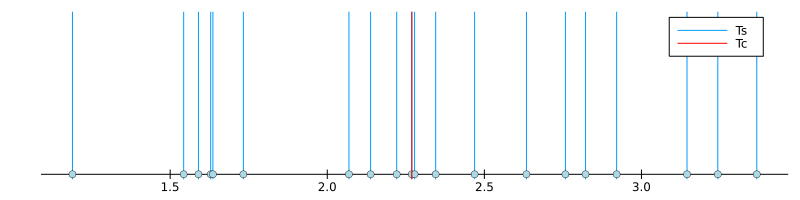

In [14]:
# visualize temperatures
using Plots
vline(Ts, grid=false, axis=:x, framestyle=:origin, xlim=(minimum(Ts)-0.1, maximum(Ts)+0.1), size=(800,200), label="Ts")
scatter!(Ts, fill(0, length(Ts)), color=:lightblue, label="")
vline!([IsingTc], color=:red, label="Tc")

In [15]:
confs = Dict{Float64, Array{Float64,3}}() # key: T, value: confs
for T in Ts
    println("T = $T"); flush(stdout);
        c = montecarlo(L=20, T=T)
            confs[T] = cat(c..., dims=3)
                println("Done.\n")
                end

T = 1.189
Started: 31.Aug 2021 17:29
Ended: 31.Aug 2021 17:30
Duration: 0.87 minutesDone.

T = 1.543
Started: 31.Aug 2021 17:30
Ended: 31.Aug 2021 17:31
Duration: 0.90 minutesDone.

T = 1.59
Started: 31.Aug 2021 17:31
Ended: 31.Aug 2021 17:32
Duration: 0.90 minutesDone.

T = 1.629
Started: 31.Aug 2021 17:32
Ended: 31.Aug 2021 17:33
Duration: 0.90 minutesDone.

T = 1.636
Started: 31.Aug 2021 17:33
Ended: 31.Aug 2021 17:34
Duration: 0.90 minutesDone.

T = 1.733
Started: 31.Aug 2021 17:34
Ended: 31.Aug 2021 17:35
Duration: 0.91 minutesDone.

T = 2.069
Started: 31.Aug 2021 17:35
Ended: 31.Aug 2021 17:36
Duration: 0.98 minutesDone.

T = 2.138
Started: 31.Aug 2021 17:36
Ended: 31.Aug 2021 17:37
Duration: 1.00 minutesDone.

T = 2.221
Started: 31.Aug 2021 17:37
Ended: 31.Aug 2021 17:38
Duration: 1.04 minutesDone.

T = 2.269
Started: 31.Aug 2021 17:38
Ended: 31.Aug 2021 17:39
Duration: 1.04 minutesDone.

T = 2.278
Started: 31.Aug 2021 17:39
Ended: 31.Aug 2021 17:40
Duration: 1.05 minutesDone.



In [16]:
using Flux
using Flux: crossentropy, onecold, onehotbatch, params, throttle, @epochs
using Statistics, Random

In [17]:
function flatten_and_Z2(confs, T)
    c = confs[T]
    cs = Float64.(reshape(c, (L^2,:))) # flatten space dimension (change L^2 to be dimension of space)
    cs = hcat(cs, -one(eltype(cs)) .* cs) # concatenate Z2 (spin flip) symmetry partners
    return cs
end

flatten_and_Z2 (generic function with 1 method)

In [18]:
L = 20
Tleft = 1.189
Tright = 3.367

confs_left = flatten_and_Z2(confs, Tleft)
confs_right = flatten_and_Z2(confs, Tright);

In [19]:
# visualize configurations
printconfs(confs) = plot([heatmap(Gray.(reshape(confs[:,i], (L,L))), ticks=false) for i in 1:100:size(confs, 2)]...)

printconfs (generic function with 1 method)

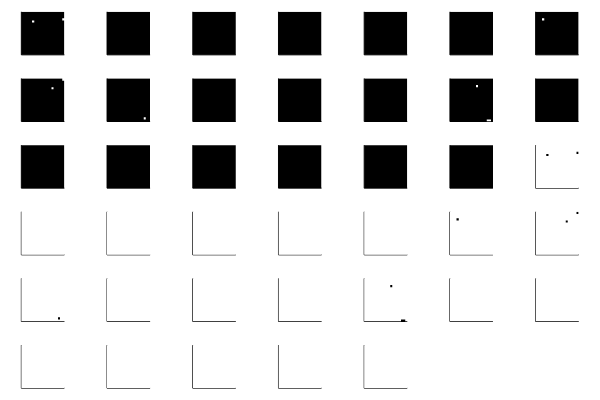

In [20]:
printconfs(confs_left)

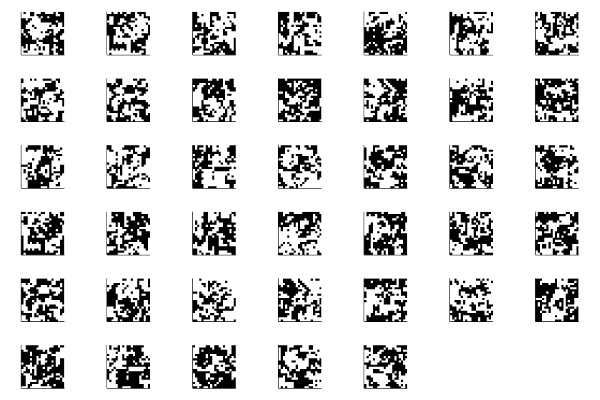

In [21]:
printconfs(confs_right)

In [22]:
# set up as training data
neach = size(confs_left, 2)
X = hcat(confs_left, confs_right)
labels = vcat(fill(1, neach), fill(0, neach))
Y = onehotbatch(labels, 0:1)
dataset = Base.Iterators.repeated((X, Y), 10); # repeat dataset 10 times

In [23]:
Random.seed!(123)

m = Chain(
    Dense(L^2, 20, relu), # 20 hidden neurons
    Dense(20, 2), # two output neurons for paramagnetic vs ferromagnetic
    softmax)

Chain(
  Dense(400, 20, relu),                 # 8_020 parameters
  Dense(20, 2),                         # 42 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 8_062 parameters, 31.742 KiB.

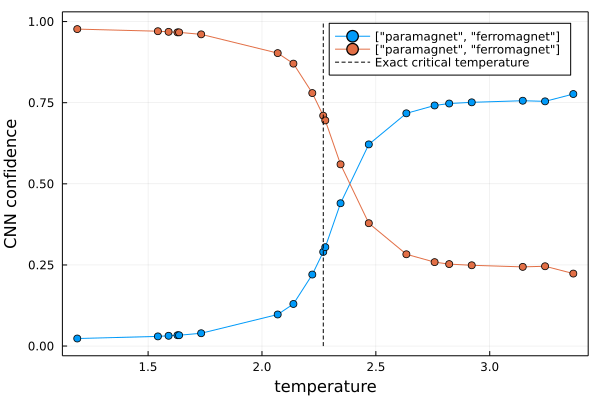

In [32]:
# classify phases at all intermediate temperatures
function confidence_plot()
    results = Dict{Float64, Vector{Float32}}()
    for T in Ts
      c = flatten_and_Z2(confs, T);
      results[T] = vec(mean(m(c), dims=2))
    end
    results = sort(results)

    p = plot(keys(results) |> collect, reduce(hcat, values(results))',
      marker=:circle,
      xlab="temperature",
      ylabel="CNN confidence",
      labels=["paramagnet", "ferromagnet"],
      frame=:box)
    plot!(p, [IsingTc, IsingTc], [0, 1], ls=:dash, color=:black, label="Exact critical temperature")
    if (@isdefined IJulia)
        # "animation" in jupyter
        IJulia.clear_output(true)
    end
    display(p)
end

confidence_plot()

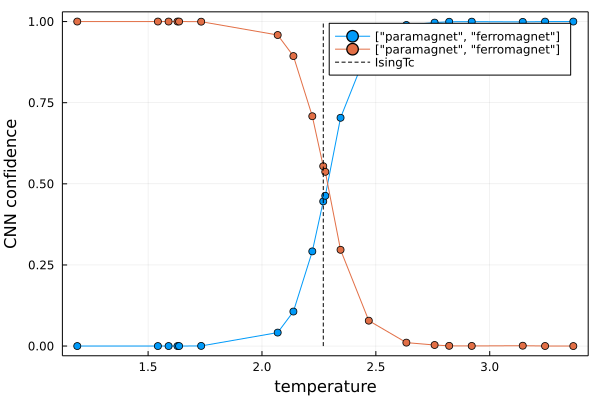

In [26]:
n= 1000 # number of epochs to train
# define cost-function
loss(x, y) = crossentropy(m(x), y)

# define optimizer
opt = ADAM()

# train for n epochs
for i in 1:n
    Flux.train!(loss, params(m), dataset, opt)
end

# 
confidence_plot()

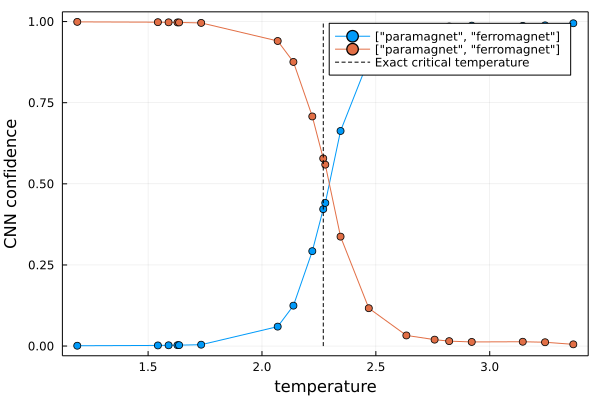

In [47]:
n= 100 # number of epochs to train
# # Define a callback
 evalcb = () -> begin
# #     @show(loss(X, Y))
# #     @show(accuracy(X, Y))
     confidence_plot()
 end

# # Reset the network and the optimizer
 Random.seed!(123)
 m = Chain(
     Dense(L^2, 20, relu),
     Dense(20, 2),
     softmax)
 opt = RADAM()
 

# # Train for 100 epochs (with "animation")
 for i in 1:n
     Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 50))
 end